In [199]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy.sparse import linalg
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from mpl_toolkits.mplot3d import axes3d




# Task 1 Neural networks

In [200]:
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data() 
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) 
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10) 
    return (x_train, y_train), (x_val, y_val)

# 1.1 Multi-layer perceptron (MLP)

# 1.1.1
First, a multilayer perceptron (MLP) is used to analysis the data. MLP generally consists of an input layer, some hidden layers and an output layer, where the input layer consists of the same number of neurons as the number of features. When a data point is passed into the MLP, this forms the input layer, which is then propagated to the next layers with some weights, biases and activation functions until it reaches the output layer. This process is called forward propagation.

The MLP built for the first task consists of 5 hidden layers, each with 400 neurons. tanh(x) was used as the activation function in all the hidden layers. Since this is classification problem with 10 classes, the output layer was chosen to have 10 neurons with the activation softmax(x), so that the softmax could scaled each neuron into the range [0,1], while all the neurons can sum to 1. Hence, the output layer can be considered as a probabilty vector.

The forward propagation can summarised as followed:
\begin{equation}
\begin{aligned}
\mathbf{h}^{(0)} &:=\mathbf{x} \\
\mathbf{h}^{(k)} &=\sigma\left(\mathbf{W}^{(k-1)} \mathbf{h}^{(k-1)}+\mathbf{b}^{(k-1)}\right), \quad k=1, \ldots, 5\\
\hat{\mathbf{y}} &=\sigma_{\text {out }}\left(\mathbf{w}^{(5)} \mathbf{h}^{(5)}+b^{(5)}\right)
\end{aligned}
\end{equation}

where we have also defined
\begin{equation}
\begin{array}{c}
\mathbf{a}^{(k)}=\mathbf{W}^{(k-1)} \mathbf{h}^{(k-1)}+\mathbf{b}^{(k-1)} \\
\mathbf{h}^{(k)}=\sigma\left(\mathbf{a}^{(k)}\right)
\end{array}
\tag{1}
\end{equation}
\begin{equation}
\sigma_{\text {out }}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} 
\end{equation}
\begin{equation}
\sigma(x) = \frac{e^{x}-e^{-x}}{e^{-x}+e^{x}}
\end{equation}

In order to train the MLP, the loss function is defined to be the categorical cross entropy:

\begin{equation}
Loss=-\sum_{i} y_{i} \log \left(\hat{y}_{i}\right)
\end{equation}
where $\hat{y}_{i}$ is the predicted probability for class $i$ and $y_{i}$ is the true probabilty of for class $i$.

To achieve an optimal model, the loss function needs to be minised with respect to the weights and biases, using stochastic gradient descent. The derivatives of the loss with respect to these parameters were computed using backpropagation, which can be derivated using chain rules:

(1) Calculate the all the pre-activations and post activations by forward propagation.

(2) Evaluate $\delta^{(L+1)}=\frac{\partial L_{i}}{\partial \mathbf{a}^{(L+1)}}$ for the output neurons, which is simply $\hat{y}_{i} - {y}_{i}$ in the case of the softmax activation fucntion.

(3) Backpropagate the errors to compute $\delta^{(k)}$ for each hidden unit using $\delta^{(k)}=$ $\sigma^{\prime}\left(\mathbf{a}^{(k)}\right)\left(\mathbf{W}^{(k)}\right)^{T} \delta^{(k+1)}$ and calculate the the derivatives on the corresponding layers : $\frac{\partial L_{i}}{\partial w_{p q}^{(k)}}=$ $\delta_{p}^{(k+1)} h_{q}^{(k)}, \quad \frac{\partial L_{i}}{\partial b_{p}^{(k)}}=\delta_{p}^{(k+1)}$

Stochastic gradient descent (SGD) is a commonly used optimisation technique in deep learning. In SGD, we divide the whole dataset into batches for each epoch, and we compute the loss for one batch at a time:
$$
L\left(\theta_{t} ; \mathcal{D}_{m}\right)=\frac{1}{M} \sum_{x_{i}, y_{i} \in \mathcal{D}_{m}} l\left(y_{i}, f_{\theta_{t}}\left(x_{i}\right)\right)
$$
where $\mathcal{D}_{m}$ is a minibatch of training data, $M=\left|\mathcal{D}_{m}\right|$ is the number of data points in the batch. We then use the gradient descent to update the parameters for that batch:
$$
\theta_{t+1}=\theta_{t}-\eta \nabla_{\theta_{t}} L\left(\theta_{t} ; \mathcal{D}_{m}\right), \quad t \in \mathbb{N}_{0}
$$

This procedure is then repeated for all the other batches. An epoch is defined to be each time the whole dataset (ie. all the batches) has been passed to the network once.

Here the activation fucntions and their derivatives were implemented.

In [201]:
# Activation functions
def tanh(h):
    # h: K x h_out array of pre-activations
    # returns: K x h_out output array 
    h = np.tanh(h)  ## <-- post-activations
    return h

def softmax(h): 
    h = np.exp(h)/np.sum(np.exp(h), axis = 0)
    return h

def tanh_deriv(h):
     return 1 - np.square(tanh(h))
    
def softmax_deriv(h): #delete
    return np.array(softmax(h) / (1-softmax(h)))

The following functions create the layers and forward-propagate the input data.

In [202]:
def layers(num_feat, num_hid_neu, num_out_neu):
    var0 = 2. / (num_feat + num_hid_neu)
    W0 = np.random.randn(num_hid_neu, num_feat) * np.sqrt(var0)
    b0 = np.zeros(num_hid_neu).reshape(400,1)

    var1 = 2. / (num_hid_neu + num_hid_neu)
    W1 = np.random.randn(num_hid_neu, num_hid_neu) * np.sqrt(var1)
    b1 = np.zeros(num_hid_neu).reshape(400,1)

    var2 = 2. / (num_hid_neu + num_hid_neu)
    W2 = np.random.randn(num_hid_neu, num_hid_neu) * np.sqrt(var2)
    b2 = np.zeros(num_hid_neu).reshape(400,1)

    var3 = 2. / (num_hid_neu + num_hid_neu)
    W3 = np.random.randn(num_hid_neu, num_hid_neu) * np.sqrt(var3)
    b3 = np.zeros(num_hid_neu).reshape(400,1)

    var4 = 2. / (num_hid_neu + num_hid_neu)
    W4 = np.random.randn(num_hid_neu, num_hid_neu) * np.sqrt(var4)
    b4 = np.zeros(num_hid_neu).reshape(400,1)

    var5 = 2. / (num_out_neu + num_hid_neu)
    W5 = np.random.randn(num_out_neu, num_hid_neu) * np.sqrt(var5)
    b5 = np.zeros(10).reshape(10,1)
    
    return W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5

def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b +  np.dot(W, x) ## <-- pre-activations
    return h


def mlp(x, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5): 
    
    a_k_lst = [x] 
    h_k_lst = [x]
    
    h = dense(x, W0, b0)
    a_k_lst.append(h)
    
    h = tanh(h)
    h_k_lst.append(h)
    
    h = dense(h, W1, b1)
    a_k_lst.append(h)
    
    h = tanh(h)
    h_k_lst.append(h)
    
    h = dense(h, W2, b2)
    a_k_lst.append(h)
    
    h = tanh(h)
    h_k_lst.append(h)
    
    h = dense(h, W3, b3)
    a_k_lst.append(h)
    
    h = tanh(h)
    h_k_lst.append(h)
    
    h = dense(h, W4, b4)
    a_k_lst.append(h)
    
    h = tanh(h)
    h_k_lst.append(h)
    
    y = dense(h, W5, b5)
    a_k_lst.append(y)
    
    y = softmax(y) 
    h_k_lst.append(y)
    
    return y, a_k_lst, h_k_lst

Now define the accuracy and loss function.

In [203]:
def loss(y_pred, y_true, batch_size = 128):
    # Define the loss function to be categorical cross entropy
    num_sample = y_pred.shape[1]
    ce = - sum(np.sum(y_true* np.log(y_pred), axis = 0))/num_sample
        
    return ce

def delta_last(y_pred, y_true):
    delta = y_pred - y_true
    return delta

def accuracy(y_pred, y_hat):
    num_sample = y_pred.shape[1]
    acc = np.sum(np.argmax(y_pred, axis = 0) == np.argmax(y_hat, axis =0))/num_sample
    return acc
    

Now backpropagation is used to compute the derivatives.

In [319]:
def backpropagation(delta2, W1, a1):

    return tanh_deriv(a1) * (W1.T @ delta2)


def find_grad(delta6, W0, W1, W2, W3, W4, W5, a_k_lst, h_k_lst, num_data = 128):
      
    delta5 = backpropagation(delta6, W5, a_k_lst[5])
    delta4 = backpropagation(delta5, W4, a_k_lst[4])
    delta3 = backpropagation(delta4, W3, a_k_lst[3])
    delta2 = backpropagation(delta3, W2, a_k_lst[2])
    delta1 = backpropagation(delta2, W1, a_k_lst[1])
    
    dW5 = (delta6 @ h_k_lst[5].T)/num_data #calculating the derivatives of the weight
    dW4 = (delta5 @ h_k_lst[4].T)/num_data
    dW3 = (delta4 @ h_k_lst[3].T)/num_data
    dW2 = (delta3 @ h_k_lst[2].T)/num_data
    dW1 = (delta2 @ h_k_lst[1].T)/num_data
    dW0 = (delta1 @ h_k_lst[0].T)/num_data
    
    db5 = np.mean(delta6, axis = 1, keepdims = True) # calculating the derivtives of the biases
    db4 = np.mean(delta5, axis = 1, keepdims = True)
    db3 = np.mean(delta4, axis = 1, keepdims = True)
    db2 = np.mean(delta3, axis = 1, keepdims = True)
    db1 = np.mean(delta2, axis = 1, keepdims = True)
    db0 = np.mean(delta1, axis = 1, keepdims = True)
    
    return dW0, dW1, dW2, dW3, dW4, dW5, db0, db1, db2, db3, db4, db5

Now the following functions use stochastic gradient descent to minimise the cost function.

In [320]:
def gd(x, y, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, l_rate = 0.01):
    
    n = x.shape[1]
    y_hat, a_k_lst, h_k_lst = mlp(x, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5)
    
    #computing the delta in the last layer
    delta6 = delta_last(y_hat, y)
    
    #calculate the gradient
    dW0, dW1, dW2, dW3, dW4, dW5, db0, db1, db2, db3, db4, db5 = find_grad(delta6, W0, W1, W2, W3, W4, 
                                                                           W5, a_k_lst, h_k_lst, num_data = n)
    # Gradient descent
    W5 -= l_rate*dW5
    W4 -= l_rate*dW4
    W3 -= l_rate*dW3
    W2 -= l_rate*dW2
    W1 -= l_rate*dW1
    W0 -= l_rate*dW0
    
    b5 -= l_rate*db5
    b4 -= l_rate*db4
    b3 -= l_rate*db3
    b2 -= l_rate*db2
    b1 -= l_rate*db1
    b0 -= l_rate*db0
        
    
    return W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, loss(y_hat, y), accuracy(y_hat, y)
    


def mlp_train(x, y, x_val, y_val, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, epoch = 40, l_rate = 0.01):
    
    y_hat = mlp(x, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5)[0] #evaluating on the train and validation 
    y_hat2 = mlp(x_val, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5)[0]
    
    loss_lst1 = [loss(y_hat, y)]
    acc_lst1 = [accuracy(y_hat, y)]
    
    loss_lst2 = [loss(y_hat2, y_val)]
    acc_lst2 = [accuracy(y_hat2, y_val)]
    
    #concatenate the data so that it can be shuffled together later
    data_merge = np.concatenate((x, y), axis = 0).T
    
    
    for j in range(epoch):
        if j%5 == 0:
            print('epoch:',j)
        np.random.shuffle(data_merge)
        x_train_shuffle = data_merge.T[:3072, :]
        y_train_shuffle = data_merge.T[3072:, :]
        #create the batches
        x_batches_lst = np.array_split(x_train_shuffle, 391, axis = 1)
        y_batches_lst = np.array_split(y_train_shuffle, 391, axis = 1)
        # gradient descent to update the parameters
        for i in range(391):
            W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, loss_batch, acc_batch = gd(x_batches_lst[i], y_batches_lst[i], 
                                                                                       W0, W1, W2, W3, W4, W5, b0, b1, b2, 
                                                                                       b3, b4, b5, l_rate = l_rate)
        y_hat = mlp(x, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5)[0] #evaluating on the train and validation 
        y_hat2 = mlp(x_val, W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5)[0]
        #
        loss_lst1.append(loss(y_hat, y))
        acc_lst1.append(accuracy(y_hat, y))
        
        loss_lst2.append(loss(y_hat2, y_val))
        acc_lst2.append(accuracy(y_hat2, y_val))
        
    return loss_lst1, acc_lst1, loss_lst2, acc_lst2

Now the data is imported.

In [71]:
(x_train, y_train), (x_val, y_val) = load_data()
#flattening the data
x_train_flatten = []
for i in range(len(x_train)):
    x_train_flatten.append(x_train[i].flatten()) #.reshape(3072, 1))

# taking the tranpose so the data is stacked by columns
x_train_flatten = np.array(x_train_flatten).T

y_train_T = y_train.T

#flattening the data
x_val_flatten = []
for i in range(len(x_val)):
    x_val_flatten.append(x_val[i].flatten())

# taking the tranpose so the data is stacked by columns
x_val_flatten = np.array(x_val_flatten).T

y_val_T = y_val.T


First, the MLP was trained on batches of 128 with learning rate 0.01 for 40 epochs.

In [321]:
#initialise the parameters before training
W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5 = layers(3072, 400, 10)

start_time = time.time()
# training
loss_lst1, acc_lst1, loss_lst2, acc_lst2 = mlp_train(x_train_flatten, y_train_T, x_val_flatten, y_val_T, W0,
                                                     W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, 
                                                     epoch = 40, l_rate = 0.01)


end_time = time.time()
print('run time:', end_time - start_time)


epoch: 0
epoch: 5
epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
run time: 1137.4818890094757


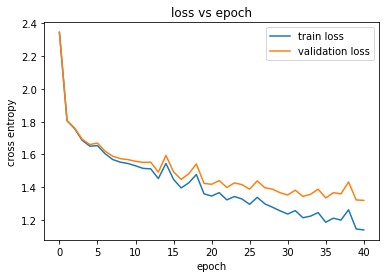

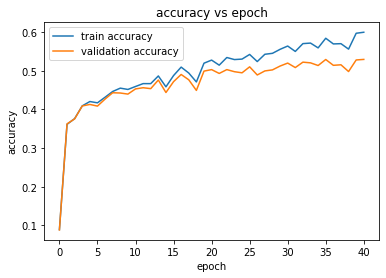

In [322]:
plt.figure(7)
plt.title('loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('cross entropy')

plt.plot(loss_lst1, label = 'train loss')
plt.plot(loss_lst2, label = 'validation loss')
plt.legend()

plt.figure(8)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.plot(acc_lst1, label = 'train accuracy')
plt.plot(acc_lst2, label = 'validation accuracy')
plt.legend()

From the graph there is a clear indication that the train and validation loss are decreasing over the 40 epochs and that both accuracy of the model is improving. There are also indications that the model is starting to converge towards the end of the training process. However, it also appears that the convergence is not complete and that more epochs are required for the both loss to level off. 

# 1.1.2

Now the MLP was trained on batches of 128 with learning rate 0.0001 for 40 epochs.

In [310]:
#initialise the parameters before training
W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5 = layers(3072, 400, 10)

start_time = time.time()

#training
loss_lst1_2, acc_lst1_2, loss_lst2_2, acc_lst2_2 = mlp_train(x_train_flatten, y_train_T, x_val_flatten, y_val_T, W0,
                                                     W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, 
                                                     epoch = 40, l_rate = 0.0001)


end_time = time.time()
print('run time:', end_time - start_time)



epoch: 0
epoch: 5
epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
run time: 1136.1525230407715


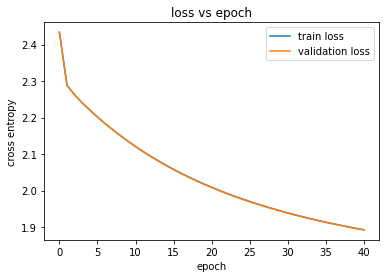

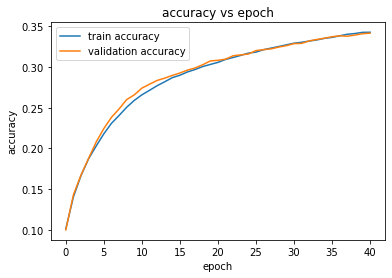

In [311]:
plt.figure(7)
plt.title('loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.plot(loss_lst1_2, label = 'train loss')
plt.plot(loss_lst2_2, label = 'validation loss')
plt.legend()
plt.figure(8)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.plot(acc_lst1_2, label = 'train accuracy')
plt.plot(acc_lst2_2, label = 'validation accuracy')
plt.legend()

Again there is a clear indication that both losses are decreasing over the 40 epochs and that both accuracies of the model are improving. However, the changes in the accuracy and loss are smoother than the first MLP and there is also an indication of the model starting to converge. However, it is also clear that the convergence is slow, since there is less improvement to the model than the first MLP. This is due to  the smaller learning rate. Moreover, it can be also be seen that train and validation losses and accuracies improve at very close rate and that there is less gap between the two compared to the first MLP. This is again is due to the smaller step size, which in turns leads to slow change to model and little overfitting (little gap between the train and validation performance).

Now the MLP was trained on batches of 128 with learning rate 0.1 for 40 epochs.

In [312]:
W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5 = layers(3072, 400, 10) #initialise the parameters before training

start_time = time.time()
#training
loss_lst1_3, acc_lst1_3, loss_lst2_3, acc_lst2_3 = mlp_train(x_train_flatten, y_train_T, x_val_flatten, y_val_T, 
                                                             W0,W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, 
                                                             epoch = 40, l_rate = 0.1)

end_time = time.time()
print('run time:', end_time - start_time)



epoch: 0
epoch: 5
epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
run time: 1103.070149898529


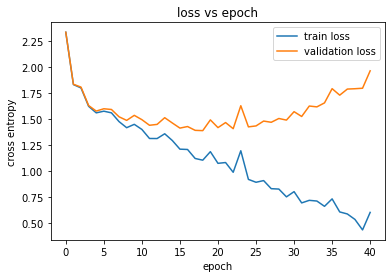

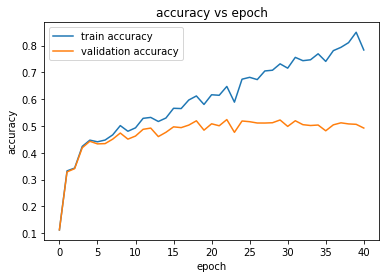

In [313]:
plt.figure(7)
plt.title('loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.plot(loss_lst1_3, label = 'train loss')
plt.plot(loss_lst2_3, label = 'validation loss')
plt.legend()
plt.figure(8)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.plot(acc_lst1_3, label = 'train accuracy')
plt.plot(acc_lst2_3, label = 'validation accuracy')
plt.legend()

As expected from the above arguement, the larger learning rate here causes a faster improvement in the loss and accuracy in the training set. Moreover, there are again signs of convergence, particular in the validation accuracy, which seems to suggest further training would lead to little improvement. However, it is also clear that there exists now a wide gap between the training loss (and accuracy) and the validation loss (and accuracy) compared to previous model. This is due to the larger step size, which in turns leads to fast convergence to model and more overfitting (larger gap between the train and validation performance).

There is in fact an indication of overfitting, since the validation loss is in fact increasing while the training loss is decreasing in the later epochs. This is particular obvious with the learning rate of 0.1 because a larger learning rate speeds up the training process which results in the the model being overfit in earlier epochs compared to the previous training model.

A subplot was created to compare the convergence of the above models.

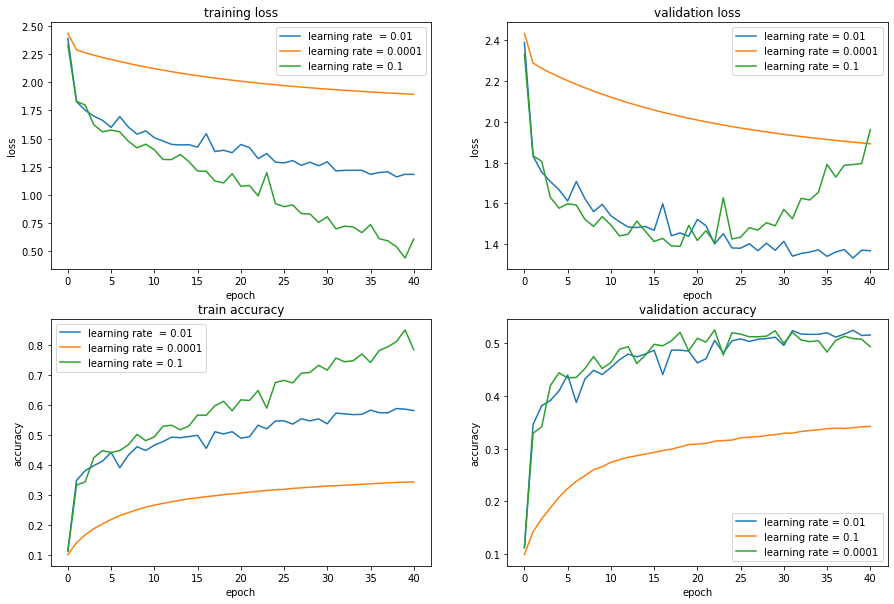

In [314]:

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0,0].set_title('training loss')
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('loss')
ax[0,0].plot(loss_lst1, label = 'learning rate  = 0.01')
ax[0,0].plot(loss_lst1_2, label = 'learning rate = 0.0001')
ax[0,0].plot(loss_lst1_3, label = 'learning rate = 0.1')
ax[0,0].legend()

ax[0,1].set_title('validation loss')
ax[0,1].plot(loss_lst2, label = 'learning rate = 0.01')
ax[0,1].plot(loss_lst2_2, label = 'learning rate = 0.0001')
ax[0,1].plot(loss_lst2_3, label = 'learning rate = 0.1')
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('loss')
ax[0,1].legend()

ax[1,0].set_title('train accuracy')
ax[1,0].plot(acc_lst1, label = 'learning rate  = 0.01')
ax[1,0].plot(acc_lst1_2, label = 'learning rate = 0.0001')
ax[1,0].plot(acc_lst1_3, label = 'learning rate = 0.1')
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('accuracy')
ax[1,0].legend()

ax[1,1].set_title('validation accuracy')
ax[1,1].plot(acc_lst2, label = 'learning rate = 0.01')
ax[1,1].plot(acc_lst2_2, label = 'learning rate = 0.1')
ax[1,1].plot(acc_lst2_3, label = 'learning rate = 0.0001')
ax[1,1].set_xlabel('epoch')
ax[1,1].set_ylabel('accuracy')
ax[1,1].legend()

From the subplot above, we can see that the largest learning rate (0.1) has the fastest convergence from the four metrics. This due again due to a large stepsize. Moreover, the overfitting can be more clearly seen from the above subplots, where the validation accuracy seems to start to decreasing slightly in the last few epochs. Therefore, further training is unlikely to have improvement on the model. 

Moreover, it is noticable that although the MLP with learning rate of 0.01 has a slower convergence, it in fact has a better validation accuracy than the one with learning rate of 0.1 towards the end of training. This is of course due to the ovefitting of the model with learning rate 0.1. On the other hand, the MLP with the smallest learning rate has the slowest convergence and that there are little improvement in loss and accuracies after 40 epochs. This is due to the small learning rate.

# 1.1.3

Now the MLP was trained on batches of 128 with learning rate 0.01 for 80 epochs.

In [315]:
W0, W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5 = layers(3072, 400, 10) #initialise the parameters before training

#training
start_time = time.time()
loss_lst1_4, acc_lst1_4, loss_lst2_4, acc_lst2_4 = mlp_train(x_train_flatten, y_train_T, x_val_flatten, y_val_T, W0,
                                                     W1, W2, W3, W4, W5, b0, b1, b2, b3, b4, b5, 
                                                     epoch = 80, l_rate = 0.01)


end_time = time.time()
print('run time:', end_time - start_time)


epoch: 0
epoch: 5
epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
epoch: 40
epoch: 45
epoch: 50
epoch: 55
epoch: 60
epoch: 65
epoch: 70
epoch: 75
run time: 2183.3356399536133


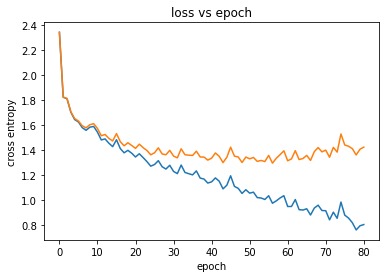

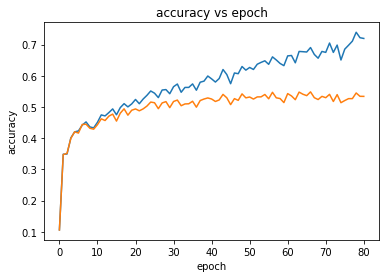

In [316]:
plt.figure(7)
plt.title('loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.plot(loss_lst1_4)
plt.plot(loss_lst2_4)

plt.figure(8)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.plot(acc_lst1_4)
plt.plot(acc_lst2_4)

By training with 80 epochs, we can now see a much clearer convergence in the vaidation loss and accuracy. This in suggests that at this point, the network is sufficiently trained, as further training would likely to result in overfitting (as the training model above).

In [317]:
mlp_mat = np.array([[acc_lst1[-1], acc_lst2[-1]],
          [acc_lst1_2[-1], acc_lst2_2[-1]],
          [acc_lst1_3[-1], acc_lst2_3[-1]],
          [acc_lst1_4[-1], acc_lst2_4[-1]]])
df_mlp_mat = pd.DataFrame(mlp_mat)

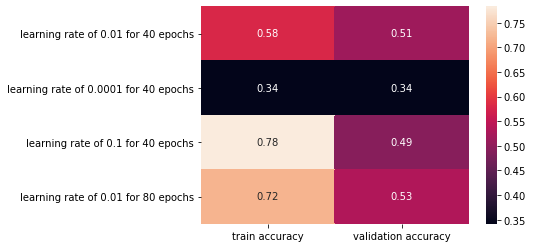

In [318]:
df_mlp_mat.columns = ['train accuracy', 'validation accuracy']
df_mlp_mat.index = ['learning rate of 0.01 for 40 epochs', 'learning rate of 0.0001 for 40 epochs',
                   'learning rate of 0.1 for 40 epochs', 'learning rate of 0.01 for 80 epochs']
sns.heatmap(df_mlp_mat, annot = True)

The performances of four trained MLPs can be summarised in the table above. It is therefore clear that the learning rate is a very important hyperparameter in this case because it actually determines the stepsize of each iteration which is given by learning rate multiplying the gradient. The small learning rate of 0.0001 has the lowest validation and train accuracy, because of the slow convergence (training is not complete after 40 epochs). The MLP trained with a learning rate of 0.1 for 40 epochs has the highest train accuracy but was outperformed by the one with learning rate of 0.01, because a large learning rate led a fast convergence in the train data, which in turn ovefitted the the data. The table also suggests the MLP trained with a learning rate of 0.01 for 80 epochs is the best model and this makes mathematical sense because a medium learning rate and 80 epochs seem to be a balance of overfitting and underfitting.

# 1.2 Convolutional neural network
A convolutional neural network is similar to the multilayer percepton where we propagate the data through layers with weights, biases and activation functions to get an output. However, the input is a rank 3 tensor instead of a flatten vector, which therefore contain information such as location of features and colours. The convolutional layers use the cross-correlation operation (equivalent to a 2-D discrete convolution) to pick up features by a kernel matrix across the image, which then returns a featuremap:
\begin{equation}
(\mathbf{h} * \mathbf{k})(i, j)=\sum_{m, n} h(i+m, j+n) k(m, n)
\end{equation}
Then there is a max pooling layer which reduces the dimension of a layer but taking the maximum neuron value in a region.

In this subtask, a convolutional neural network is constructed with four hidden layers in total, where the first three layers are convolutional and the last is a fully connected layer. Each layer applies a (3,3) feature map, with the first ues 32 and the last two use 64, with a (2,2) max pooling layer between each layer. Relu is chosen to be the activation function between all layers except the last which uses softmax.

In [29]:
from tensorflow.keras import Sequential, regularizers # pause
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data() 
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) 
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10) 
    return ((x_train, y_train), (x_val, y_val))


In [31]:
(x_train, y_train), (x_val, y_val) = load_data()
x_train_tf = tf.convert_to_tensor(x_train)
y_train_tf = tf.convert_to_tensor(y_train)

# 1.2.1

The CNN is built and was trined on batches of 28 using stochastic gradient descent for 40 epoches with learning rate of 0.1.

In [206]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # pause before Conv2D, and after each arg
    MaxPool2D((2, 2)), # pause before arg
    Conv2D(64, (3,3), activation='relu'),  # pause after each arg
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
    
])

In [207]:
stochastic_gd = tf.keras.optimizers.SGD(learning_rate=0.1) #define the sgd with appropiate step size

In [208]:
model.compile(optimizer = stochastic_gd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [209]:
#training
start = time.time()
history = model.fit(x_train_tf, y_train_tf, validation_data = (x_val, y_val), epochs =40, 
                    batch_size = 128, verbose = 0)
end = time.time()
run_time = end - start
print('run time: ', run_time, 's')

run time:  1663.1852717399597 s


Graphs were created to visualise the convergence of the model.

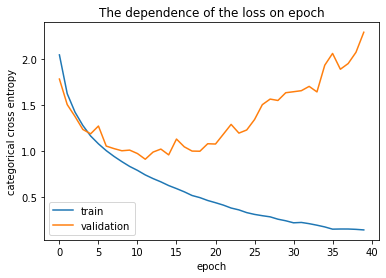

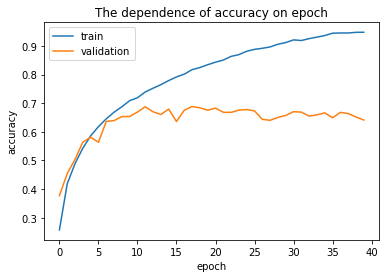

In [36]:
plt.figure(1)
plt.title('The dependence of the loss on epoch')
plt.xlabel('epoch')
plt.ylabel('categorical cross entropy')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()

plt.figure(2)
plt.title('The dependence of accuracy on epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()

Now we can evaluate the performance of the model.

In [37]:
model.evaluate(x_val, y_val)

313/313 [==============================] - 2s 8ms/step - loss: 2.2954 - accuracy: 0.6411


[2.295398235321045, 0.6410999894142151]

From the graphs above, there is a clear convergence in both the train and validation loss and accuracies (in particular the validation accuracy). There is also a clear indication of overfitting from about epoch 15 where the validation loss starts increasing while the train loss keeps decreasing, while the validation accuracy can be seen to level off. The fact that there is a gap between the train and validation accuracy also suggests overfitting. Hence further training is likely to lead to little improvement to the validation accuracy.

# 1.2.2
To avoid overfitting L2 regularisation is used. L2 regularisation is analogous to ridge regression where a regularisation parameter is introduced to the loss function:
\begin{equation}
L(\mathbf{w}, \alpha)=L_{0}(\mathbf{w})+\alpha_{1} \sum_{i}\left||w_{i}\right||^{2}
\end{equation}

The regularisation parameter introduces 'bias-variance trade off' to the model where the regularisation parameter can shrink elements in the weight matrices reducing the complexity of the model which in turns increase bias and reduce variance, and hence reduce overfitting.

In [38]:
model_1 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer = regularizers.l2(0.005), activation='relu', input_shape=(32, 32, 3)),  # pause before Conv2D, and after each arg
    MaxPool2D((2, 2)), # pause before arg
    Conv2D(64, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.005)),  # pause after each arg
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer = regularizers.l2(0.005)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
    
])

In [39]:
model_1.compile(optimizer = stochastic_gd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [40]:
start_2 = time.time() #training
history_1 = model_1.fit(x_train_tf, y_train_tf, validation_data = (x_val, y_val), epochs =40, 
                        batch_size = 128, verbose = 0)
end_2 = time.time()
run_time2 = end_2 - start_2
print(f'run time with L2 : {run_time2}')

run time with L2 : 1525.1167488098145


Graphs were created to visualise the convergence of this model.

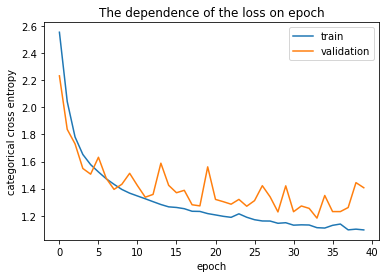

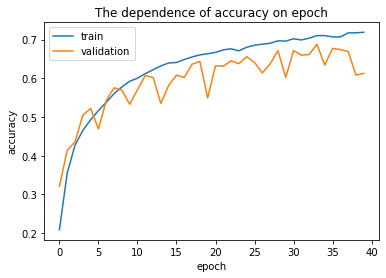

In [41]:
plt.figure(1)
plt.title('The dependence of the loss on epoch')
plt.xlabel('epoch')
plt.ylabel('categorical cross entropy')
plt.plot(history_1.history['loss'], label = 'train')
plt.plot(history_1.history['val_loss'], label = 'validation')
plt.legend()
plt.figure(2)
plt.title('The dependence of accuracy on epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history_1.history['accuracy'], label = 'train')
plt.plot(history_1.history['val_accuracy'], label = 'validation')
plt.legend()

Now we can evaluate the performance of the model.



In [42]:
model_1.evaluate(x_val, y_val)

313/313 [==============================] - 2s 8ms/step - loss: 1.4067 - accuracy: 0.6126


[1.406707525253296, 0.6126000285148621]

# 1.2.3
Dropout was also used as a regularisation method to avoid overfitting by randomly replacing some columns of the weight matrices with zeros. However, when the CNN is validated, the complete network is used, with the weight matrices are scaled by the dropout probabilty.

In [43]:
model_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), 
    MaxPool2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),  
    MaxPool2D((2,2)),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
    
])

In [45]:
model_dropout.compile(optimizer = stochastic_gd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
start_dropout = time.time()
history_dropout = model_dropout.fit(x_train_tf, y_train_tf, validation_data = (x_val, y_val), 
                                    epochs =40, batch_size = 128, verbose = 0)
end_dropout = time.time()
run_time_dropout = end_dropout - start_dropout
print(f'run time with dropout: {run_time_dropout}')

run time with dropout: 2126.574177980423


Now we can evaluate the performance of the dropout model.

In [46]:
model_dropout.evaluate(x_val, y_val)
print(f'run time: {end_dropout - start_dropout}')

313/313 [==============================] - 3s 10ms/step - loss: 0.8171 - accuracy: 0.7201
run time: 2126.574177980423


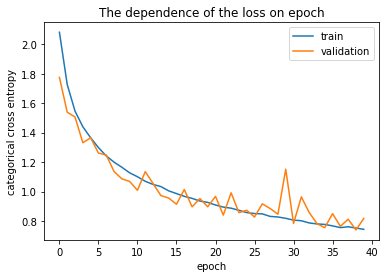

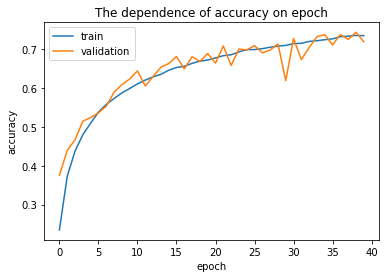

In [47]:
plt.figure(1)
plt.title('The dependence of the loss on epoch')
plt.xlabel('epoch')
plt.ylabel('categorical cross entropy')
plt.plot(history_dropout.history['loss'], label = 'train')
plt.plot(history_dropout.history['val_loss'],label = 'validation')
plt.legend()
plt.figure(2)
plt.title('The dependence of accuracy on epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history_dropout.history['accuracy'], label = 'train')
plt.plot(history_dropout.history['val_accuracy'], label = 'validation')
plt.legend()

Early stopping is used as another regularisation method, which works by stopping the training before the completing all epochs, when the training process starts to overfit (little change or decrease in validation error/loss). This again reduces the complexity of the model, reducing overfitting.

In [48]:
model_es = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # pause before Conv2D, and after each arg
    MaxPool2D((2, 2)), # pause before arg
    Conv2D(64, (3,3), activation='relu'),  # pause after each arg
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
    
])

In [49]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [50]:
model_es.compile(optimizer = stochastic_gd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [51]:
start_es = time.time()
history_es = model_es.fit(x_train_tf, y_train_tf, validation_data = (x_val, y_val), epochs =40, 
                       batch_size = 128, callbacks = [earlystopping], verbose = 0)
end_es = time.time()
run_time_es = end_es - start_es
print(f'run time with early stopping: {run_time_es}')

run time with early stopping: 674.1856410503387


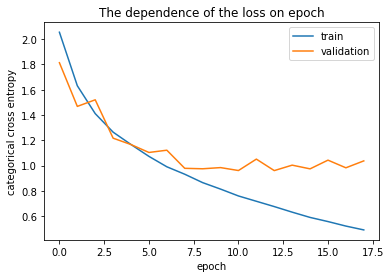

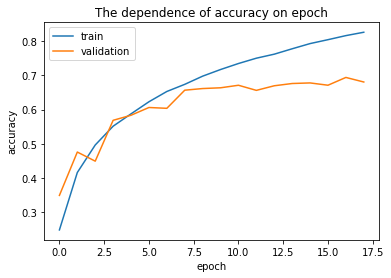

In [52]:
plt.figure(1)
plt.title('The dependence of the loss on epoch')
plt.xlabel('epoch')
plt.ylabel('categorical cross entropy')
plt.plot(history_es.history['loss'], label = 'train')
plt.plot(history_es.history['val_loss'], label = 'validation')
plt.legend()
plt.figure(2)
plt.title('The dependence of accuracy on epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(history_es.history['accuracy'], label = 'train')
plt.plot(history_es.history['val_accuracy'], label = 'validation')
plt.legend()

As a result, the training stops after 19epochs, which clearly reduces the overfitting as indicated by the graphs above (training stopped before the validation loss started to rise again). This in fact also reduces the computational time for training.

In [53]:
# calculate the train and validation loss and accuracies for each CNN model
val_model_es = model_es.evaluate(x_val, y_val)
val_model = model.evaluate(x_val, y_val)
val_model_dropout = model_dropout.evaluate(x_val, y_val)
val_model_1 = model_1.evaluate(x_val, y_val)

train_model_es = model_es.evaluate(x_train, y_train)
train_model = model.evaluate(x_train, y_train)
train_model_dropout = model_dropout.evaluate(x_train, y_train)
train_model_1 = model_1.evaluate(x_train, y_train)

1563/1563 [==============================] - 13s 8ms/step - loss: 1.2017 - accuracy: 0.6746


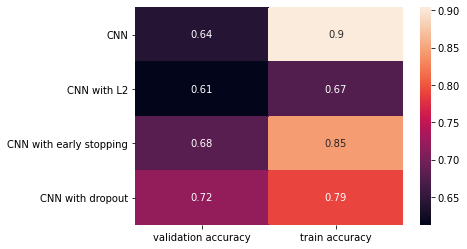

In [54]:
cnn_compare_matrix = np.array([[val_model[1], train_model[1]],
                               [val_model_1[1], train_model_1[1]],
                               [val_model_es[1], train_model_es[1]],
                               [val_model_dropout[1], train_model_dropout[1]]])

df_cnn_compare_matrix = pd.DataFrame(cnn_compare_matrix)
df_cnn_compare_matrix.columns = ['validation accuracy', 'train accuracy']
df_cnn_compare_matrix.index = ['CNN', 'CNN with L2', 'CNN with early stopping', 'CNN with dropout']
sns.heatmap(df_cnn_compare_matrix,annot = True)

From the table above, it can be seen that CNN with dropout has a better accuracy than that with the L2 regularisation. The choices of using which regularisation methods usually depend hugely on the data. In the dropout method, some neurons are set to zero in each iteration, meaning in every iteration the network is in fact slightly different which can hugely decreaseing correlations between layers because layer-layer connections are 'interrupted', reducing the noisy features being propagated. This can in fact improve the robustness of the network [1].

In contrast, in L2 where the network structure is the same in each iteration. Instead of setting some neurons to zero, a penalty term is introduced to the loss function (as discussed above), shrinking the parameters. Hence, there could still exist non-negligible correlations between layers, meaning random fluctuations in the data may still be highlighted in the L2 regularisation. This may be why dropout gives better accuracy in this task.

However, the L2 regularisation CNN has higher validation accuracy than that of early stopping. This is because the formulation of CNN with early stopping is simply the same as the standard CNN. Therefore, not much difference can be observed between the CNN and the CNN with early stopping and hence has less accurate results than that of L2 regularisation.

# 1.2.4

A table was created to compare the performance of the MLP (obtained from 1.1.1) and that of the CNN with dropout (obtained from 1.2.3).

In [282]:
cnn_vs_mlp_mat = np.array([[train_model_dropout[1], val_model_dropout[1], end_dropout - start_dropout, int(122570)], 
                           [acc_lst1[-1], acc_lst2[-1], 1253.72, int(1874810)]])

df_cnn_vs_mlp = pd.DataFrame(cnn_vs_mlp_mat)
df_cnn_vs_mlp.columns = ['train accuracy', 'validation accuracy', 'computational time (s)', 'number of parameters']
df_cnn_vs_mlp.index = ['CNN with dropout', 'MLP']
df_cnn_vs_mlp

train accuracy  validation accuracy  computational time (s)  \
CNN with dropout         0.79112               0.7201             2126.574178   
MLP                      0.60814               0.5367             1253.720000   

                  number of parameters  
CNN with dropout              122570.0  
MLP                          1874810.0

As summarised in the table above, the CNN with dropout outperforms the MLP in both the train and validation accuracy. This is in fact expected because CNN can capture the higher dimension features better (ie. spatial features and colours). Moreover, dropout in CNN also redueces the overfitting from the training process. However, it is also clear that CNN requires almost twice the computational time of MLP because the convolution operation is computationally time consuming and the CNN has extra dropout and max pooling layers which increase the number of operations of the network. Therefore, although MLP has more parameters, CNN still has more operations. [2]

# Task 2: Unsupervised learning

In [145]:
X = pd.read_csv('feature_matrix_karate_club.csv').to_numpy()
X_k = X[:,1:]


In [146]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [147]:
X_normalise = normalize(X_k)

# 2.1 Clustering of the feature matrix

The k means clustering algorithm is used to analyse the data, which aims to find the optimal number of cluster, k, to group the data such that the data points within each cluster are 'similar'. For a given k, the algorithm works by first randomly assign every data point to one of the k clusters, from which the centroids are computed as follows:
\begin{equation}
\mathbf{m}_{l}=\frac{1}{\left|c_{l}\right|} \sum_{i \in c_{l}} \mathbf{x}^{(i)}, \quad l=1, \ldots, k
\end{equation}

Then each data point is then reassign to its closest centroid. This is then iterated until there is no change in assignment for all the data points.

In [148]:
def k_means(X, k, random_seed = 0):
    
    n_samples, n_features = X.shape

    
    # labels: assign every sample to a cluster at random
    np.random.seed(random_seed)
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
      centroids[i] = np.mean([x[0:-1]   for x in X_labels if x[-1]==i], axis=0)#[0:-1]   

    ## EDIT THIS CELL

    max_iter = 15
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)    
            
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                  centroids[c] = np.mean(X[labels==c], axis=0)  
                
    X_labels[:,-1] = new_labels
    return centroids, X_labels
    ## <-- EDIT THIS LINE

# 2.1.1
In order to find the optimal number of clusters, the within distance is used as a measure of disimilarility:
\begin{equation}
W(\mathcal{C})=\frac{1}{2} \sum_{l=1}^{k} \frac{1}{\left|c_{l}\right|} \sum_{i, j \in c_{l}}\left\|\mathbf{x}^{(i)}-\mathbf{x}^{(j)}\right\|^{2}
\end{equation}
However, since different random initialisations can lead to different results, while having the same number clusters. 

The `euclidian_distance` and `within_distance` functions calculate the squared distance between two vectors and calculate the within distance for k-means cluster.

In [149]:
def euclidian_distance(p, q):
    
    return np.sum((p-q)**2, axis=1)

In [291]:
def within_distance(X_labels):
    labels = X_labels[:,-1]
    X = X_labels[:,:-1]
    cluster_list = set(labels) # getting the unique cluster labels
    within_dist = 0
    
    for c in cluster_list:
        
        sum_1 = 0
        
        if (labels == c).any():
            for row in range(len(X[labels == c])): # loop to calculate the within distance every point
                
                sum_1 += sum(euclidian_distance(X[labels == c][row], X[labels == c]))

        within_dist += 0.5 * sum_1/len(X[labels == c])  #divide it by two
        #print(within_dist)
    return within_dist

100 random initialisations were created for each k from which the average within-distance for each k was calculated.

In [292]:
within_dist_lst = []
k_values = range(2,11)
for k in k_values:
    within_dist_mean = 0
    for i in range(100): # create 100 initialisations
        X_labels = k_means(X_normalise, k, random_seed = 4* i)[1]
        within_dist_mean += within_distance(X_labels)/100
        
    within_dist_lst.append(within_dist_mean)


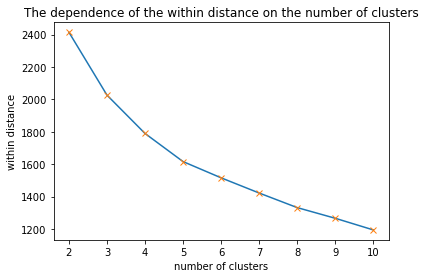

In [293]:
plt.xlabel('number of clusters')
plt.ylabel('within distance')
plt.title('The dependence of the within distance on the number of clusters')
plt.plot(k_values, within_dist_lst)
plt.plot(k_values, within_dist_lst, 'x')

Generally, the 'elbow method' can be used to find the smallest k, after which there is little decrease to the within-distance. However, the 'elbow' of this plot is not very clear because the graph is smooth, although some may argue that k = 5 is the elbow and hence is the optimal cluster. However, due to the unclear 'elbow', other ways to determine the optimal cluster should be considered before concluding 5 is the optimal cluster(eg. CH score).

# 2.1.2 
However, one may also argue that k = 4 is not a clear 'elbow'. Hence, other measures such as the Calinski-Harabasz (CH) score should also be used to determined the optimal k, which is defined as follows:


$$
s=\frac{\operatorname{tr}\left(B_{k}\right)}{\operatorname{tr}\left(W_{k}\right)} \times \frac{n-k}{k-1}
$$

where n is the total number of data, $W_{k}$ and $B_{k}$ are the the within dispersion and group dispersion which are defined as follows:
$$
\begin{array}{l}
W_{k}=\sum_{q=1}^{k} \sum_{x \in C_{4}}\left(x-c_{q}\right)\left(x-c_{q}\right)^{T} \\
B_{k}=\sum_{q=1}^{k} n_{\eta}\left(c_{q}-c_{E}\right)\left(c_{q}-c_{E}\right)^{T}
\end{array}
$$
where $c_{q}$ is the centroid of cluster $q$ and $c_{E}$ is the centroid of all the data.

equation found in https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c

The `euclidian_distance_1` and `within_dispersion` functions compute the within dispersion $W_{k}$.

In [153]:
def euclidian_distance_1(p, q):
    dist = np.linalg.norm(p-q)
    return np.sum((p-q)**2, axis=0)

In [296]:
def within_dispersion(X_labels, centroids):
    labels = X_labels[:,-1]
    #print(set(labels))
    
    X = X_labels[:,:-1]
    cluster_list = list(map(int, list(set(labels))))
    within_disp = 0
    
    
    for c in cluster_list:
        
        sum_1 = 0
        
        if (labels == c).any():
            
            
            for row in range(len(X[labels == c])):
                
                sum_1 += euclidian_distance_1(X[labels == c][row], centroids[c])

        within_disp += sum_1 
    return within_disp

The `group_dispersion` function then calculates the group dispersion $B_{k}$.

In [155]:
def group_dispersion(X_labels, centroids):
    labels = X_labels[:,-1]
    X = X_labels[:,:-1]
    cluster_list = map(int, list(set(labels)))
    group_disp = 0
    
    centre_data = np.mean([x[0:-1]   for x in X_labels], axis=0)
    
    for c in cluster_list:
        group_disp += len(X[labels == c]) * euclidian_distance_1(centroids[c], centre_data)
        
    return group_disp

The `calinski_harabasz` function then calculates the CH score.

In [156]:
def calinski_harabasz(X_labels, centroids):
    group = group_dispersion(X_labels, centroids)
    within = within_dispersion(X_labels, centroids)
    n = len(X_labels)
    k = len(centroids)
    
    ch_score = (group/within) * ((n - k)/(k-1))
    
    return ch_score

100 random initialisations were created for each k from which the average CH score for each k was calculated.

In [157]:
ch_lst = []
k_values = range(2,11)
for k in k_values:
    ch_mean = 0
    for i in range(100):
        centroids, X_labels = k_means(X_normalise, k, random_seed = 4*i)
    
        ch_mean += calinski_harabasz(X_labels, centroids)/100
    
    ch_lst.append(ch_mean)

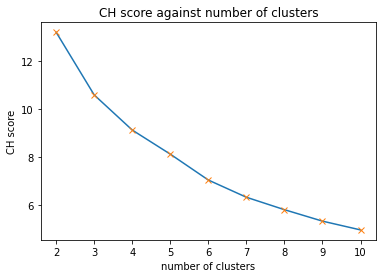

In [158]:
plt.xlabel('number of clusters')
plt.ylabel('CH score')
plt.title('CH score against number of clusters')
plt.plot(k_values, ch_lst)
plt.plot(k_values, ch_lst, 'x')

From the graph above, the optimal number of clusters is determined to be 2 since it corresponds to the largest CH score. This is different from the optimal cluster achieved from the within-cluster distance, because the two measurements are measuring different aspects of the clustering. The CH score can be interpretted a measure of how the within-cluster and out-of-cluster variabilities balance, unlike the within-distance which is a measure of the within-cluster variabilty.



# 2.1.3
For the k means algorithm, different initialisations can lead different clustering results. Therefore, it is important to measure the robustness and the variability of the clustering for each k. There are many different ways to measure the variability of clusterings, and in this task two methods were used: measureing the variance of the within-cluster distance for each k and calculating the average adjusted rand index (ARI) for each k. We can interpret the variance as a measure of dissimilarity between clusters and the ARI as a measure of similarilty between clusters. Therefore, the optimal k is then the one with a very small variance but a high ARI.

First, we calculated the variance of the within-cluster distance for each k.

In [294]:
var_lst = []
k_values = range(2,11)
for k in k_values:
    wd_lst = []
    for i in range(100): #create 100 initialisations
        X_labels = k_means(X_normalise, k, random_seed =  i)[1]
        wd_1 = within_distance(X_labels)
        wd_lst.append(wd_1)
    
    var_wd = np.var(wd_lst)
    var_lst.append(var_wd)

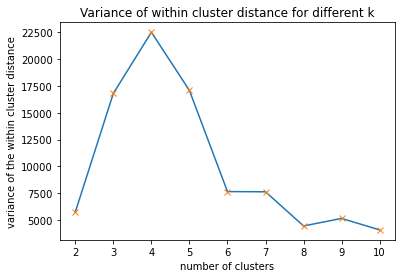

In [295]:
plt.title('Variance of within cluster distance for different k')
plt.ylabel('variance of the within cluster distance')
plt.xlabel('number of clusters')
plt.plot(k_values, var_lst)
plt.plot(k_values, var_lst, 'x')

Here we implemented the `ari` function which can compare two clusters by calculating the adjusted rand function. Further details on the adjusted rand index can be found in task 2.3.3.

In [166]:
def ari(series1, series2):
    mat_cross_tab = pd.crosstab(series1, series2).to_numpy()
    a_arr = np.sum(mat_cross_tab, axis = 1)
    b_arr = np.sum(mat_cross_tab, axis = 0)
    
    n = sum(sum(mat_cross_tab))
    sum1 = sum(sum(sc.special.binom(mat_cross_tab, 2)))
    sum2 = sum(sc.special.binom(a_arr, 2))
    sum3 = sum(sc.special.binom(b_arr, 2))
    
    top = sum1 - ((sum2 * sum3)/sc.special.binom(n, 2))
    bottom = 0.5*(sum2 + sum3) - ((sum2 * sum3)/sc.special.binom(n, 2))
    
    ari_score = top/bottom

    return ari_score

In [167]:
k_values = range(2,11)
mean_ari = []
for k in k_values:    
    init_lst = []
    for i in range(50): #finding the labels for each initilisation
        labels = k_means(X_normalise, k, random_seed = 4*i)[1][:,-1]
        init_lst.append(labels)

    ari_kmeans_lst = []
    for j in range(len(init_lst)):
        for w in range(j+1, len(init_lst)): #calculating the ari with all the other labels
            ari_kmeans = ari(pd.Series(init_lst[j]), pd.Series(init_lst[w]))
            ari_kmeans_lst.append(ari_kmeans)
    
    mean_ari.append(np.mean(ari_kmeans_lst))

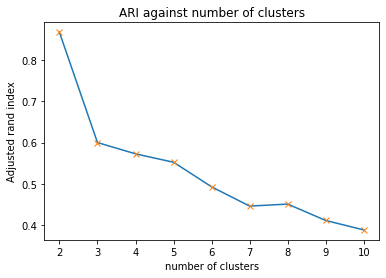

In [168]:
plt.ylabel('Adjusted rand index')
plt.xlabel('number of clusters')
plt.title('ARI against number of clusters')
plt.plot(k_values, mean_ari)
plt.plot(k_values, mean_ari, 'x')

A robust algorithm should have a low variance of within-cluster distance and a adjusted rand index close to one, which would suggest that the clusters obtained from different random initialisations have high similarity (implying a consistent and robust algorithm). From the two plots above, we can tell that k = 2 has a close to one ARI and a low variance of within-cluster distance, implying the k = 2 produces the most consistent clusterings (and is the optimal cluster). This in fact matches the result from 2.1.2 (from the CH score).



# 2.2 Dimensionality reduction of the feature matrix

In this task, principal component analysis (PCA) was used as the dimensionality reduction method for the feature matrix. In PCA, we aim to find a reduced number of descriptors while retaining most of the information given (ie. finding the componenets witht the largest variance) from all 100 descriptors, and hence the task is to find the new basis in the reduced dimensional space. This problem can be shown to be an eigenproblem for the covariance matrix and the algorithm for a $d$ dimensional PCA works where the eigenvectors with the largest eigenvectors form the first few principal axes. The procedure can be summarised as follows:
1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
2. Find $d$ largest eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.

However, it is important that the matrix $\mathbf X$ is normalised so that the variance can be comparable.

First we normalise the feature matrix.

In [169]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [170]:

X_normalise = normalize(X_k)

In [297]:
centroids_op, X_labels_op = k_means(X_normalise, 2, random_seed = 0)
labels_op = X_labels_op[:,-1]


# 2.2.1

Here PCA algorithm is implemented.

In [172]:
## EDIT THIS FUNCTION

from scipy.sparse import linalg

def pca_function(X,k):

  # create covariance matrix S
  C = 1.0/(len(X)-1) * np.dot(X.T, X) ## <-- SOLUTION


  # compute eigenvalues and eigenvectors using the eigsh scipy function
  eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

  # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
  sorted_index = np.argsort(eigenvalues)[::-1]
  eigenvalues=eigenvalues[sorted_index]
  eigenvectors=eigenvectors[:,sorted_index ]

  # transform our data
  X_pca = X.dot(eigenvectors) ## <-- SOLUTION

  return X_pca, eigenvectors, eigenvalues

Lets now apply our PCA function to create three principle components, k=3.

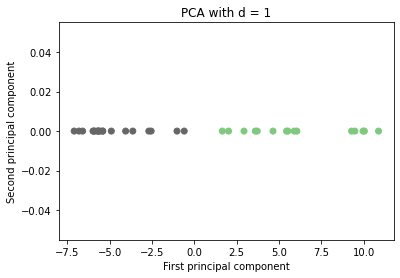

In [173]:
# compute the projection, the eigenvector and eigenvalues from our function
X_pca1, eigenvectors1, eigenvalues1 = pca_function(X_normalise,1) 

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA with d = 1')
plt.scatter(X_pca1[:,0], np.zeros((34,)), c = labels_op, cmap = 'Accent')


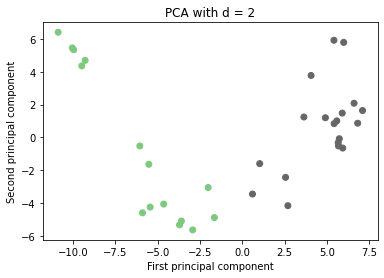

In [174]:
# compute the projection, the eigenvector and eigenvalues from our function

X_pca2, eigenvectors2, eigenvalues2 = pca_function(X_normalise,2) 
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA with d = 2')


plt.scatter(X_pca2[:,0], X_pca2[:,1], c = labels_op, cmap = 'Accent')


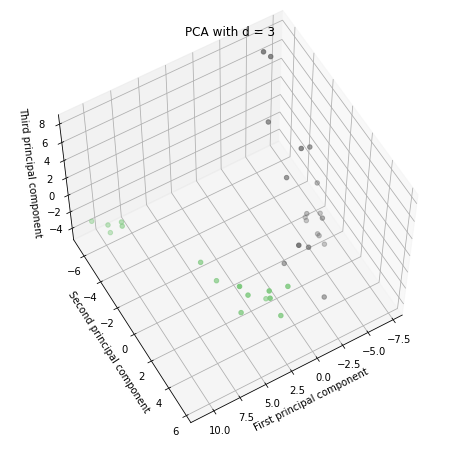

In [175]:
# compute the projection, the eigenvector and eigenvalues from our function
X_pca3, eigenvectors3, eigenvalues3 = pca_function(X_normalise,3) 

fig = plt.figure(1, figsize = (8,8))
ax = fig.add_subplot(projection= '3d')
ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c = labels_op, cmap = 'Accent')
X_pca2, eigenvectors2, eigenvalues2 = pca_function(X_normalise,2) 
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
ax.set_zlabel('Third principal component')
plt.title('PCA with d = 3')
ax.view_init(60, 60) 


One of the key applications of PCA is to visualise high dimensional data when projected in lower dimensions, hence the graphs were plotted with the labels obtained from the optimal cluster in 2.1.2 (with k = 2). Moreover, with these we can now analyse the relation between PCA and clusters. As discussed above the coordinate axes (the principal axes) above are the corresponding eigenvectors (with the largest eigenvalues) of the covariance matrix.

First, from the 1-D plot we can see that there seems to exist a point on the 1-D line such that the two clusters can be seperated perfectly (at about x = 0), which also be seen in the 2-D plot. Since the two principal axes are orthogonal, it can be interpretted that the second principal axis (since the axis goes through the origin) in fact separates the two clusters.  

To understand this, we need to understand that PCA can be interpretted as a proper orthogonal decompostion which means the first principal axis is obtained by minimising the orthogonal squared euclidean distance between the data and the axis. This in fact has great similarity to the k means algorithm, which is greedy algorithm to minimise the squared euclidean distances between data and the centroids from different initialisations. This therefore suggests that in the k = 2 case, the two centroids are likely to be located close to the first principal axis (along the first eigenvector). Since the second principal axis is orthogonal to the first and that it has to maximise the explained variance, the second principal axis is then likely to form a partition between the two clusters. This is however not always true and it depends hugely on the intrinsic properties of the data. [3]

# 2.2.2
The proportion of explained variance can be interpretted as a measure of how much information a given componenent contains and is the defined as:
\begin{equation}
Var = \dfrac{\lambda_{i}} {\sum_{i} \lambda_{i}}
\end{equation}
where $\lambda_{i}$ is the eigenvalue of the $i^{th}$ component, wich can be calculated using the spectral decompostion of the feature matrix $X^{T} X$.

Therefore, this can be interpretted as the 'proportion of information' given by the $i^{th}$ component. where 

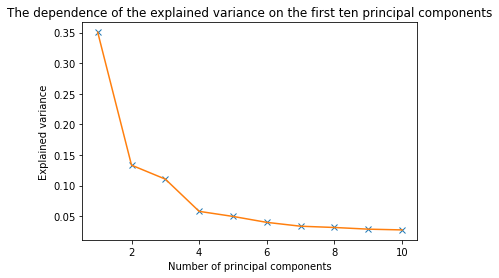

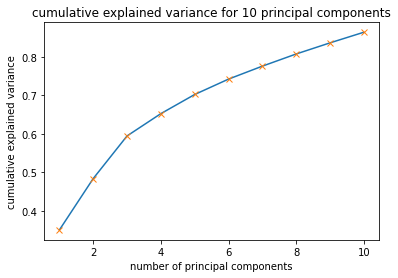

In [176]:
X_pca, eigenvectors, eigenvalues = pca_function(X_normalise, 98)
explained_variances = (eigenvalues / eigenvalues.sum())
ev_lst = []
ev_lst.append(explained_variances)

cumu_ev_lst = np.cumsum(ev_lst)

plt.figure(1)
plt.plot(range(1, 11), explained_variances[:10], 'x')
plt.plot(range(1, 11), explained_variances[:10])
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.title('The dependence of the explained variance on the first ten principal components')


plt.figure(2)
plt.title('cumulative explained variance for 10 principal components')
plt.xlabel('number of principal components')
plt.ylabel('cumulative explained variance')
plt.plot(range(1, 11), cumu_ev_lst[:10])
plt.plot(range(1, 11), cumu_ev_lst[:10], 'x')

From the cumulative plot, we can also see that the first three principal components already contain about 60% of the variance. This is also clearly indicated from the sharp derease in the proportion of explained variance for the first three components in the first plot, which suggests that the dataset can be well described with the three dimensions. 

However, if more information is required from the PCA model, one can still reduce the dimension significantly. For example, 8 dimensions can already contain up to 80% of the variance/information, which is a significant dimensionality reduction from the orginal dimension of 100.

There is a close relationship between the proportion of explained variance and the spectral decomposition of the feature. This is because, the eigenvectors and eigenvalues above are achieved from the spectral decompostion of the convariance matrix which is equivalent to a scaled $X^{T} X$. The fact that the first three explained variances are noticably larger than the rest suggest that there are three very large eigenvalues obtained from the spectral decompostion of $X^{T} X$.


# 2.3 Graph-based analysis

In [177]:
df_A = pd.read_csv('karate_club_graph.csv')
A  = df_A.to_numpy()[:, 1:]


# 2.3.1 Centralities

In graph theory, centrality is a measure of how 'important' a node is in a graph. In this task, three measures were used to compute the centralities of the nodes: PageRank, degree centrality, eigenvector centrality.

PageRank is algorithm based on the idea of a weighted random walk, which is defined as follows:
\begin{equation}
\mathbf{c}_{\mathrm{PR} t+1}=\alpha\left(A D^{-1}\right) \mathbf{c}_{\mathrm{PR} t}+(1-\alpha) \frac{\mathbf{1}}{N}
\end{equation}
where  $\mathbf{c}_{\mathrm{PR}}$ is the PageRank centrality, $A$ is the adjacency matrix, $\mathbf{1}$ is a vector of ones, $D$ is diag($A\mathbf{1}$) and $\alpha$ is a parameter in [0,1] analogous to the probabilty in random walk. The PageRank equation iterated until convergence. Therefore, the PageRank algorithmin fact takes into account of both the number of edges and the importance of the neighbours.

Degree centrality simply measures the number of contacts of a node in a graph and is defined as:
\begin{equation}
\mathbf{c}_{d}=\frac{\mathbf{d}}{2 E}=\frac{A \mathbf{1}}{2 E}
\end{equation}
where $E=\frac{1}{2} \sum_{i=1}^{N} d_{i}$. Therefore, degree centrality is in fact a very local method.

Eigenvector centrality measures the centrality of a node by summing the centrality of the nodes it is connected to:
\begin{equation}
\mathbf{c}_{e}(i)=\alpha \sum_{j} A_{i j} \mathbf{c}_{e}(j)
\end{equation}
This can in fact be expressed as a eigenproblem:
\begin{equation}
A \mathbf{c}_{e}=\lambda \mathbf{c}_{e}
\end{equation}



The iterative PageRank algorithm is implemented here such that it is iterated until there is no change to the centrality vectors.

In [249]:
def pagerank(A,alpha = 0.85):
    N = len(A)
    I = np.ones((len(A)))
    d = np.dot(A, I)
    D = np.diag(d)
    c_pr = np.ones((A.shape[0]))
    
    I = np.ones((A.shape[0]))
    run = True
    
    while run: #iterate until convergence
        
        c_pr_prev = c_pr
        c_pr = alpha * np.dot(np.matmul(A, np.linalg.inv(D)), c_pr) + ((1 - alpha)/N) * I
        
        if sum(c_pr - c_pr_prev) == 0: #breaking the loop
            run = False
    return c_pr

In [250]:
def degree_centrality(A):
    I = np.ones((len(A)))
    d = np.dot(A, I)
    E = np.sum(d)
    
    c_d = d / (2 * E)
    
    return c_d

In [251]:
def eigen_centrality(A):
    eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True)
    return eigenvector

Using the functions implemented above the three centralities were calculated and were scaled for comparison later.

In [253]:
centrality_pr = pagerank(A)/sum(pagerank(A))
centrality_dg = degree_centrality(A) / sum(degree_centrality(A)) 
centrality_eg = eigen_centrality(A).reshape(-1)/ sum(eigen_centrality(A).reshape(-1))

A dataframe was created listing the values of the three centralities for all the nodes.

In [215]:
df = pd.DataFrame(data = [centrality_pr, centrality_dg, centrality_eg]).transpose()
df.columns = ['pagerank', 'degree centrality', 'eigenvector centrality']
df


pagerank  degree centrality  eigenvector centrality
0   0.096997           0.102564                0.071413
1   0.052877           0.057692                0.053427
2   0.057079           0.064103                0.063719
3   0.035860           0.038462                0.042423
4   0.021978           0.019231                0.015261
5   0.029111           0.025641                0.015967
6   0.029111           0.025641                0.015967
7   0.024490           0.025641                0.034343
8   0.029766           0.032051                0.045682
9   0.014309           0.012821                0.020626
10  0.021978           0.019231                0.015261
11  0.009565           0.006410                0.010618
12  0.014645           0.012821                0.016925
13  0.029536           0.032051                0.045495
14  0.014536           0.012821                0.020370
15  0.014536           0.012821                0.020370
16  0.016784           0.012821                0.004748
17  0.014559           0.012821                0.018562
18  0.014536           0.012821                0.020370
19  0.019605           0.019231                0.029713
20  0.014536           0.012821                0.020370
21  0.014559           0.012821                0.018562
22  0.014536           0.012821                0.020370
23  0.031523           0.032051                0.030156
24  0.021076           0.019231                0.011461
25  0.021006           0.019231                0.011894
26  0.015044           0.012821                0.015183
27  0.025640           0.025641                0.026813
28  0.019573           0.019231                0.026332
29  0.026289           0.025641                0.027112
30  0.024590           0.025641                0.035106
31  0.037158           0.038462                0.038376
32  0.071693           0.076923                0.062002
33  0.100919           0.108974                0.075003

It can be seen that node 33 and node 0 are highly central according to the three centralities. These two nodes may correspond to the centres of clusters but this needs to be further investigated before concluding.

Pairplots and heat maps to better analyse the correlations between the rankings of the three centralities.

<Figure size 432x288 with 0 Axes>

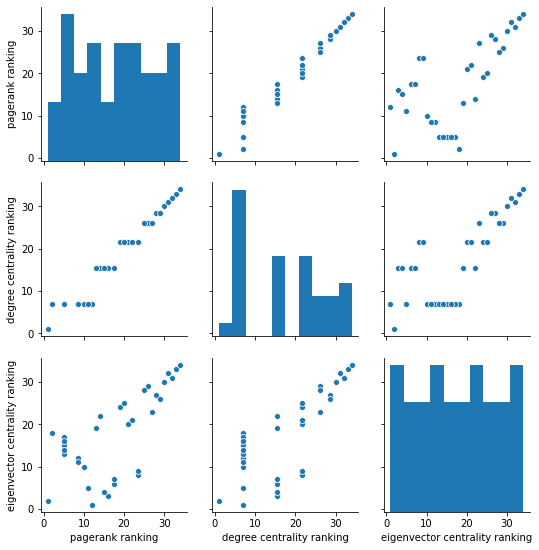

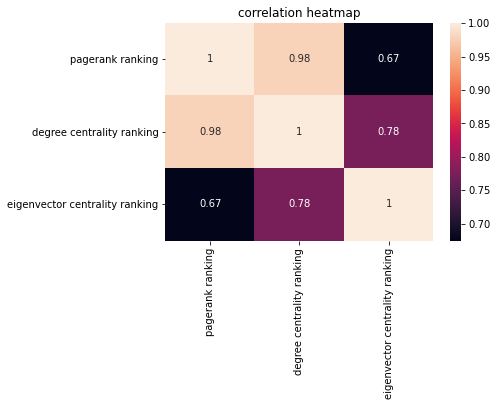

In [223]:

df_rankings = df.copy()
df_rankings['pagerank ranking'] = df_rankings['pagerank'].rank()
df_rankings['degree centrality ranking'] = df_rankings['degree centrality'].rank()
df_rankings['eigenvector centrality ranking'] = df['eigenvector centrality'].rank()

plt.figure(1)
sns.pairplot(df_rankings[['pagerank ranking', 'degree centrality ranking', 'eigenvector centrality ranking']])

plt.figure(10)
plt.title('correlation heatmap')

sns.heatmap(df_rankings[['pagerank ranking', 'degree centrality ranking', 'eigenvector centrality ranking']].corr(),
           annot = True)



From the plots above, there is a nearly perfect correlation betweent the degree centrality and the PageRank centrality, while the eigenvector centrality has correlations of 0.78 and 0.67 with the PageRank and degree centrality. The slight disagreement between the eigenvector centrality ranking and the degree centrality can be understood, because these are two very different ways of calculating the centralities (as discussed above). The degree centrality method is very local (counting number of edges) whereas the eigenvector centrality method takes into account the whole network (by calculating neighbouring centralities). On the other hand the high correlation between the PageRank and degree centrality can be understood by the fact that PageRank can in fact be shown to be nearly equivalent to degree centrality when $\alpha$ tends to one (the second term in the equation tends to zero). In this task, $\alpha$ was set to be a relatively large value (0.85) and this is may be the cause of the high correlation between the the degree centrality and PageRank [5].

# 2.3.2 Community detection



Community detection is the process to find the optimally partition a graph into communities (analgous to clusterings). To find the optimal partitions, we define the cost function to be the modularity of the graph:
\begin{equation}
Q=\frac{1}{2 E} \operatorname{Tr}\left[H^{T}\left[A-\frac{1}{2 E} \mathrm{~d} \mathbf{d}^{T}\right] H\right]
\end{equation}
$ H$ is called a membership matrix where each row corresponds to a node in the graph and each column represents a column.
However, this is a again a combinatorial problem and in this task a greedy algorithm called Clauset-Newman-Moore algorithm to use to maximise the modularity. The Algorithm works by assign each node a community, then algorithm starts combining community that gives the highest postive change in modularity [4]. This procedure is then iterated until there is no combination can change the modularity, which would be the optimal partitions.

The Clauset-Newman-Moore algorithm was implemented using Networkx as follows:

In [184]:
G = nx.from_numpy_array(A)

In [185]:
G_cluster = greedy_modularity_communities(G)
print('The optimal number of clusters is',len(G_cluster), '.')

The optimal number of clusters is 3 .


The labels were added to the attributes of nodes.

In [186]:
for j in range(len(G_cluster)):
    for i in G_cluster[j]:
        G.nodes[i]['label'] = j

A data frame was created displaying the three centrailties and label for each node.

In [187]:
cluster_labels = list(nx.get_node_attributes(G, 'label').values())
df_with_labels = df.copy()
df_with_labels['CMN label'] = cluster_labels


The network graph was created to visualise the clusters.

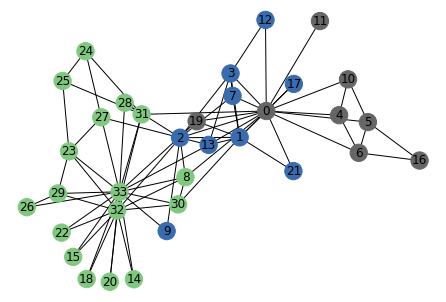

In [188]:
pos = nx.spring_layout(G)
color_map = plt.get_cmap('Accent')
nx.draw(G, pos, with_labels = True, node_color = cluster_labels, cmap = color_map)


The top 8 most central nodes according to PageRank and the corresponding labels:

In [189]:
df_pr_rank = df_with_labels[['pagerank', 'CMN label']].sort_values(by = 'pagerank', ascending = False).head(8)
df_pr_rank

pagerank  CMN label
33  0.100919          0
0   0.096997          2
32  0.071693          0
2   0.057079          1
1   0.052877          1
31  0.037158          0
3   0.035860          1
23  0.031523          0

The top 8 most central nodes according to the degree centrality and the corresponding labels:

In [190]:
df_dg_rank = df_with_labels[['degree centrality', 'CMN label']].sort_values(by = 'degree centrality', ascending = False).head(8)
df_dg_rank

degree centrality  CMN label
33           0.108974          0
0            0.102564          2
32           0.076923          0
2            0.064103          1
1            0.057692          1
3            0.038462          1
31           0.038462          0
23           0.032051          0

The distribution of the 8 most central nodes across clusters were shown here as a histogram.

(array([4., 0., 0., 0., 0., 3., 0., 0., 0., 1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

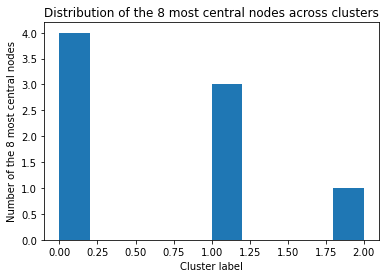

In [191]:
plt.ylabel('Number of the 8 most central nodes')
plt.xlabel('Cluster label')
plt.title('Distribution of the 8 most central nodes across clusters')
plt.hist(df_dg_rank['CMN label'])

The distribution of the top 8 most central nodes suggest that the nodes in the third cluster is less connected than those in the first and second clusters.

# 2.3.3 Comparing clusertings

Now we can compare the clusters achieved from k means and the Clauset-Newman-Moore algorithm against each other and against the ground truth clusters given using the adjusted rand index.

First we need to create the contingency table as follows:
\begin{equation}
\begin{array}{c|cccc|c}
&Y_{1} & Y_{2} & \cdots & Y_{s}  & \\
\hline X_{1} & n_{11} & n_{12} & \cdots & n_{1 s} & a_{1} \\
X_{2} & n_{21} & n_{22} & \cdots & n_{2 s} & a_{2} \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
X_{r} & n_{r 1} & n_{r 2} &  & & a_{r} \\
\hline \text {} & b_{1} & b_{2} & \cdots & b_{s} &
\end{array}
\end{equation}
where $X_{1}$, $X_{2}$, ... $X_{r}$ are the cluster labels from the first algorithm and $Y_{1}$, $Y_{2}$, ... $Y_{s}$ are the cluster labels from the second algorithm, and the elements in the table are the number of common data points in the corresponding clusters.

The ARI is then defined as:
\begin{equation}
A R I=\frac{\sum_{i j}\left(\begin{array}{c}
n_{i j} \\
2
\end{array}\right)-\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right) \sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right] /\left(\begin{array}{c}
n \\
2
\end{array}\right)}{\frac{1}{2}\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right)+\sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right]-\left[\sum_{i}\left(\begin{array}{c}
a_{i} \\
2
\end{array}\right) \sum_{j}\left(\begin{array}{c}
b_{j} \\
2
\end{array}\right)\right] /\left(\begin{array}{l}
n \\
2
\end{array}\right)}
\end{equation}

In [192]:
df_ground_truth = pd.read_csv('ground_truth_karate_club.csv')
df_ground_truth = df_ground_truth['0'].map({'Mr. Hi': 0, 'Officer': 1})


Now we create the optimal cluster from 2.1.2 again.

In [198]:
centroids_op, X_labels_op = k_means(X_normalise, 2, random_seed = 123)


A dataframe with different centralities and different clustering labels was created to summarise the information we have so far.

In [302]:
df_compare = df_with_labels.copy()
df_compare['k means label'] = X_labels_op[:, -1]
df_compare['true label'] = df_ground_truth
df_compare = df_compare.astype({'k means label' : int}, copy = False)


The adjusted rand index is implemented as follow:

In [195]:
def ari(series1, series2):
    mat_cross_tab = pd.crosstab(series1, series2).to_numpy()
    a_arr = np.sum(mat_cross_tab, axis = 1)
    b_arr = np.sum(mat_cross_tab, axis = 0)
    
    n = sum(sum(mat_cross_tab))
    sum1 = sum(sum(sc.special.binom(mat_cross_tab, 2)))
    sum2 = sum(sc.special.binom(a_arr, 2))
    sum3 = sum(sc.special.binom(b_arr, 2))
    
    top = sum1 - ((sum2 * sum3)/sc.special.binom(n, 2))
    bottom = 0.5*(sum2 + sum3) - ((sum2 * sum3)/sc.special.binom(n, 2))
    
    ari_score = top/bottom

    return ari_score

In [196]:
compare_cmn_k = ari(df_compare['CMN label'], df_compare['k means label'])
compare_k_truth = ari(df_compare['true label'], df_compare['k means label'])
compre_cmn_true = ari(df_compare['true label'], df_compare['CMN label'])

In [197]:
df_final_mat = pd.DataFrame(np.array([compare_cmn_k, compare_k_truth, compre_cmn_true]))
df_final_mat.columns = ['ARI']
df_final_mat.index = ['Clauset-Newman-Moore vs k means', 'truth vs k means', 'Clauset-Newman-Moore vs truth']
df_final_mat

ARI
Clauset-Newman-Moore vs k means -0.031487
truth vs k means                 0.001297
Clauset-Newman-Moore vs truth    0.568439

The comparison between the three clusters are summarised in the table above. The cluster achieved from the k means algorithm can be seen to have little simiarity to the ground truth cluster and the one obtained from the Clauset-Newman-Moore algorithm. On the other hand there seems to be a high similarity between the Clauset-Newman-Moore cluster and the ground truth cluster. Since the clusters were results of two different data set (feature matrix and the friendship adjacency matrix), this seems to suggest the ground truth cluster is independent of the data given by the feature matrix, and that a graph-based learning approach is better for clusterings in this case.

# References

[1] https://datascience.stackexchange.com/questions/37362/when-should-one-use-l1-l2-regularization-instead-of-dropout-layer-given-that-b

[2] https://medium.com/data-science-bootcamp/multilayer-perceptron-mlp-vs-convolutional-neural-network-in-deep-learning-c890f487a8f1

[3] https://stats.stackexchange.com/questions/183236/what-is-the-relation-between-k-means-clustering-and-pca

[4] article{Clauset_2004,
   title={Finding community structure in very large networks},
   volume={70},
   ISSN={1550-2376},
   url={http://dx.doi.org/10.1103/PhysRevE.70.066111},
   DOI={10.1103/physreve.70.066111},
   number={6},
   journal={Physical Review E},
   publisher={American Physical Society (APS)},
   author={Clauset, Aaron and Newman, M. E. J. and Moore, Cristopher},
   year={2004},
   month={Dec}
}

[5] article{Perra_2008,
   title={Spectral centrality measures in complex networks},
   volume={78},
   ISSN={1550-2376},
   url={http://dx.doi.org/10.1103/PhysRevE.78.036107},
   DOI={10.1103/physreve.78.036107},
   number={3},
   journal={Physical Review E},
   publisher={American Physical Society (APS)},
   author={Perra, Nicola and Fortunato, Santo},
   year={2008},
   month={Sep}
}


[6]  Deep learning specialisation. Andrew Ng. Coursera.